### Implementing Alexnet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

HERE you can adjust the number of classes

In [ ]:
OUTPUT_DIM = 39

model = AlexNet(OUTPUT_DIM)

def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

This is to display the number of trainable parameters.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,391,079 trainable parameters


Setting the hyperparameters and train the model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

CHOSE_LR = 1e-3

optimizer = optim.Adam(model.parameters(), lr=CHOSE_LR)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:
            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs



In [ ]:
EPOCHS = 10 # You may need to run longer to get better results. Lab example is for demo only

# keeping-track-of-losses
train_loss_alex = []
valid_losses_alex = []
train_accus_alex = []
valid_accus_alex = []

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iter, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion, device)

    train_loss_alex.append(train_loss)
    valid_losses_alex.append(valid_loss)
    train_accus_alex.append(train_acc)
    valid_accus_alex.append(valid_acc)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 1m 32s
	Train Loss: 4.465 | Train Acc: 3.05%
	 Val. Loss: 3.538 |  Val. Acc: 6.51%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 27s
	Train Loss: 3.252 | Train Acc: 10.59%
	 Val. Loss: 2.670 |  Val. Acc: 23.00%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 1m 31s
	Train Loss: 2.178 | Train Acc: 34.61%
	 Val. Loss: 1.685 |  Val. Acc: 51.65%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 1m 28s
	Train Loss: 1.465 | Train Acc: 54.34%
	 Val. Loss: 1.284 |  Val. Acc: 59.20%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 1m 30s
	Train Loss: 1.054 | Train Acc: 66.43%
	 Val. Loss: 1.148 |  Val. Acc: 66.75%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 1m 29s
	Train Loss: 0.865 | Train Acc: 72.34%
	 Val. Loss: 0.934 |  Val. Acc: 72.40%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 1m 41s
	Train Loss: 0.700 | Train Acc: 77.09%
	 Val. Loss: 0.794 |  Val. Acc: 75.26%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 37s
	Train Loss: 0.640 | Train Acc: 78.69%
	 Val. Loss: 0.900 |  Val. Acc: 75.52%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 1m 41s
	Train Loss: 0.544 | Train Acc: 82.33%
	 Val. Loss: 0.769 |  Val. Acc: 80.12%


Training:   0%|          | 0/121 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 40s
	Train Loss: 0.502 | Train Acc: 84.40%
	 Val. Loss: 0.741 |  Val. Acc: 80.99%


Example code to plot losses.

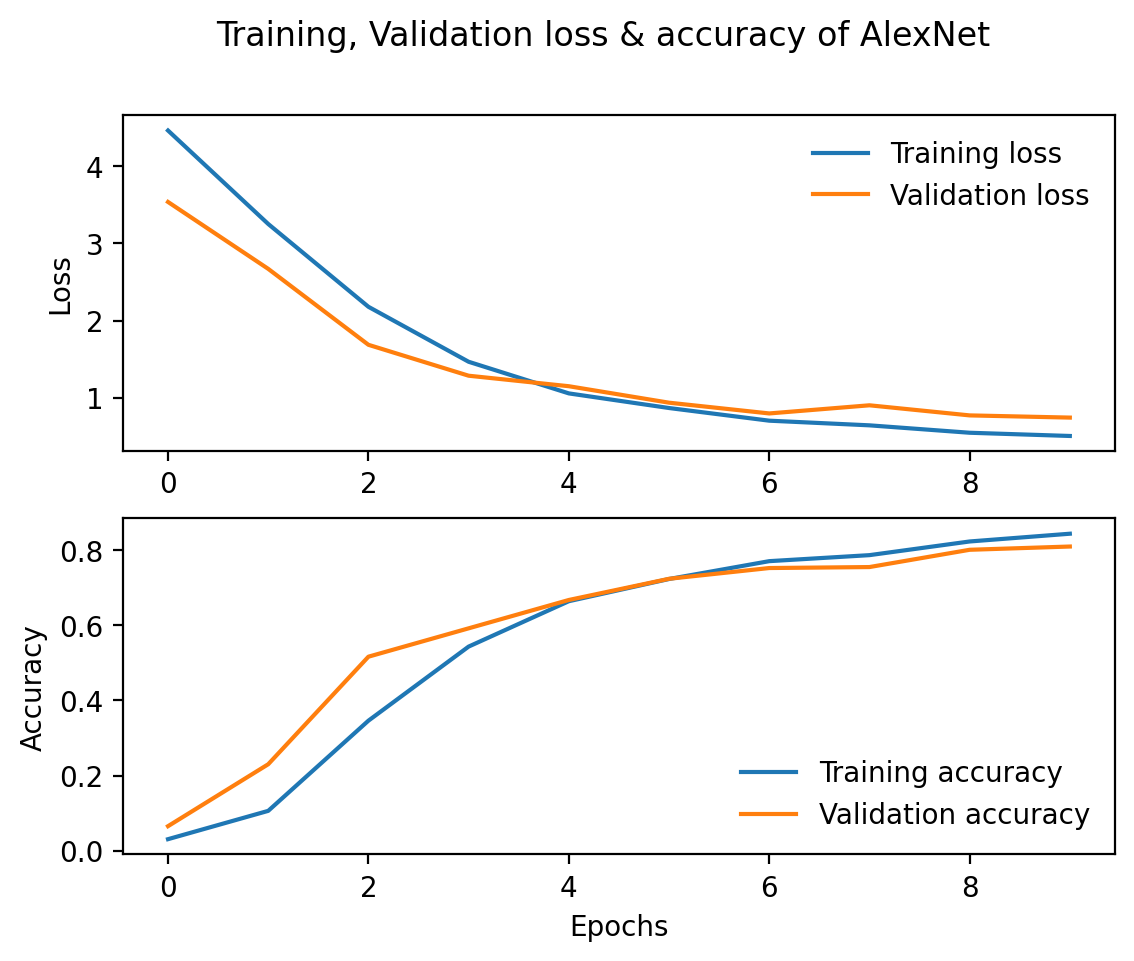

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Training, Validation loss & accuracy of AlexNet')
ax1.plot(train_loss_alex, label='Training loss')
ax1.plot(valid_losses_alex, label='Validation loss')
# ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend(frameon=False)

ax2.plot(train_accus_alex, label='Training accuracy')
ax2.plot(valid_accus_alex, label='Validation accuracy')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend(frameon=False)

### Loading the best model

In [ ]:
model.load_state_dict(torch.load('best-model.pt'))

<All keys matched successfully>

In [ ]:
images, labels, probs = get_predictions(model, test_iter, device)

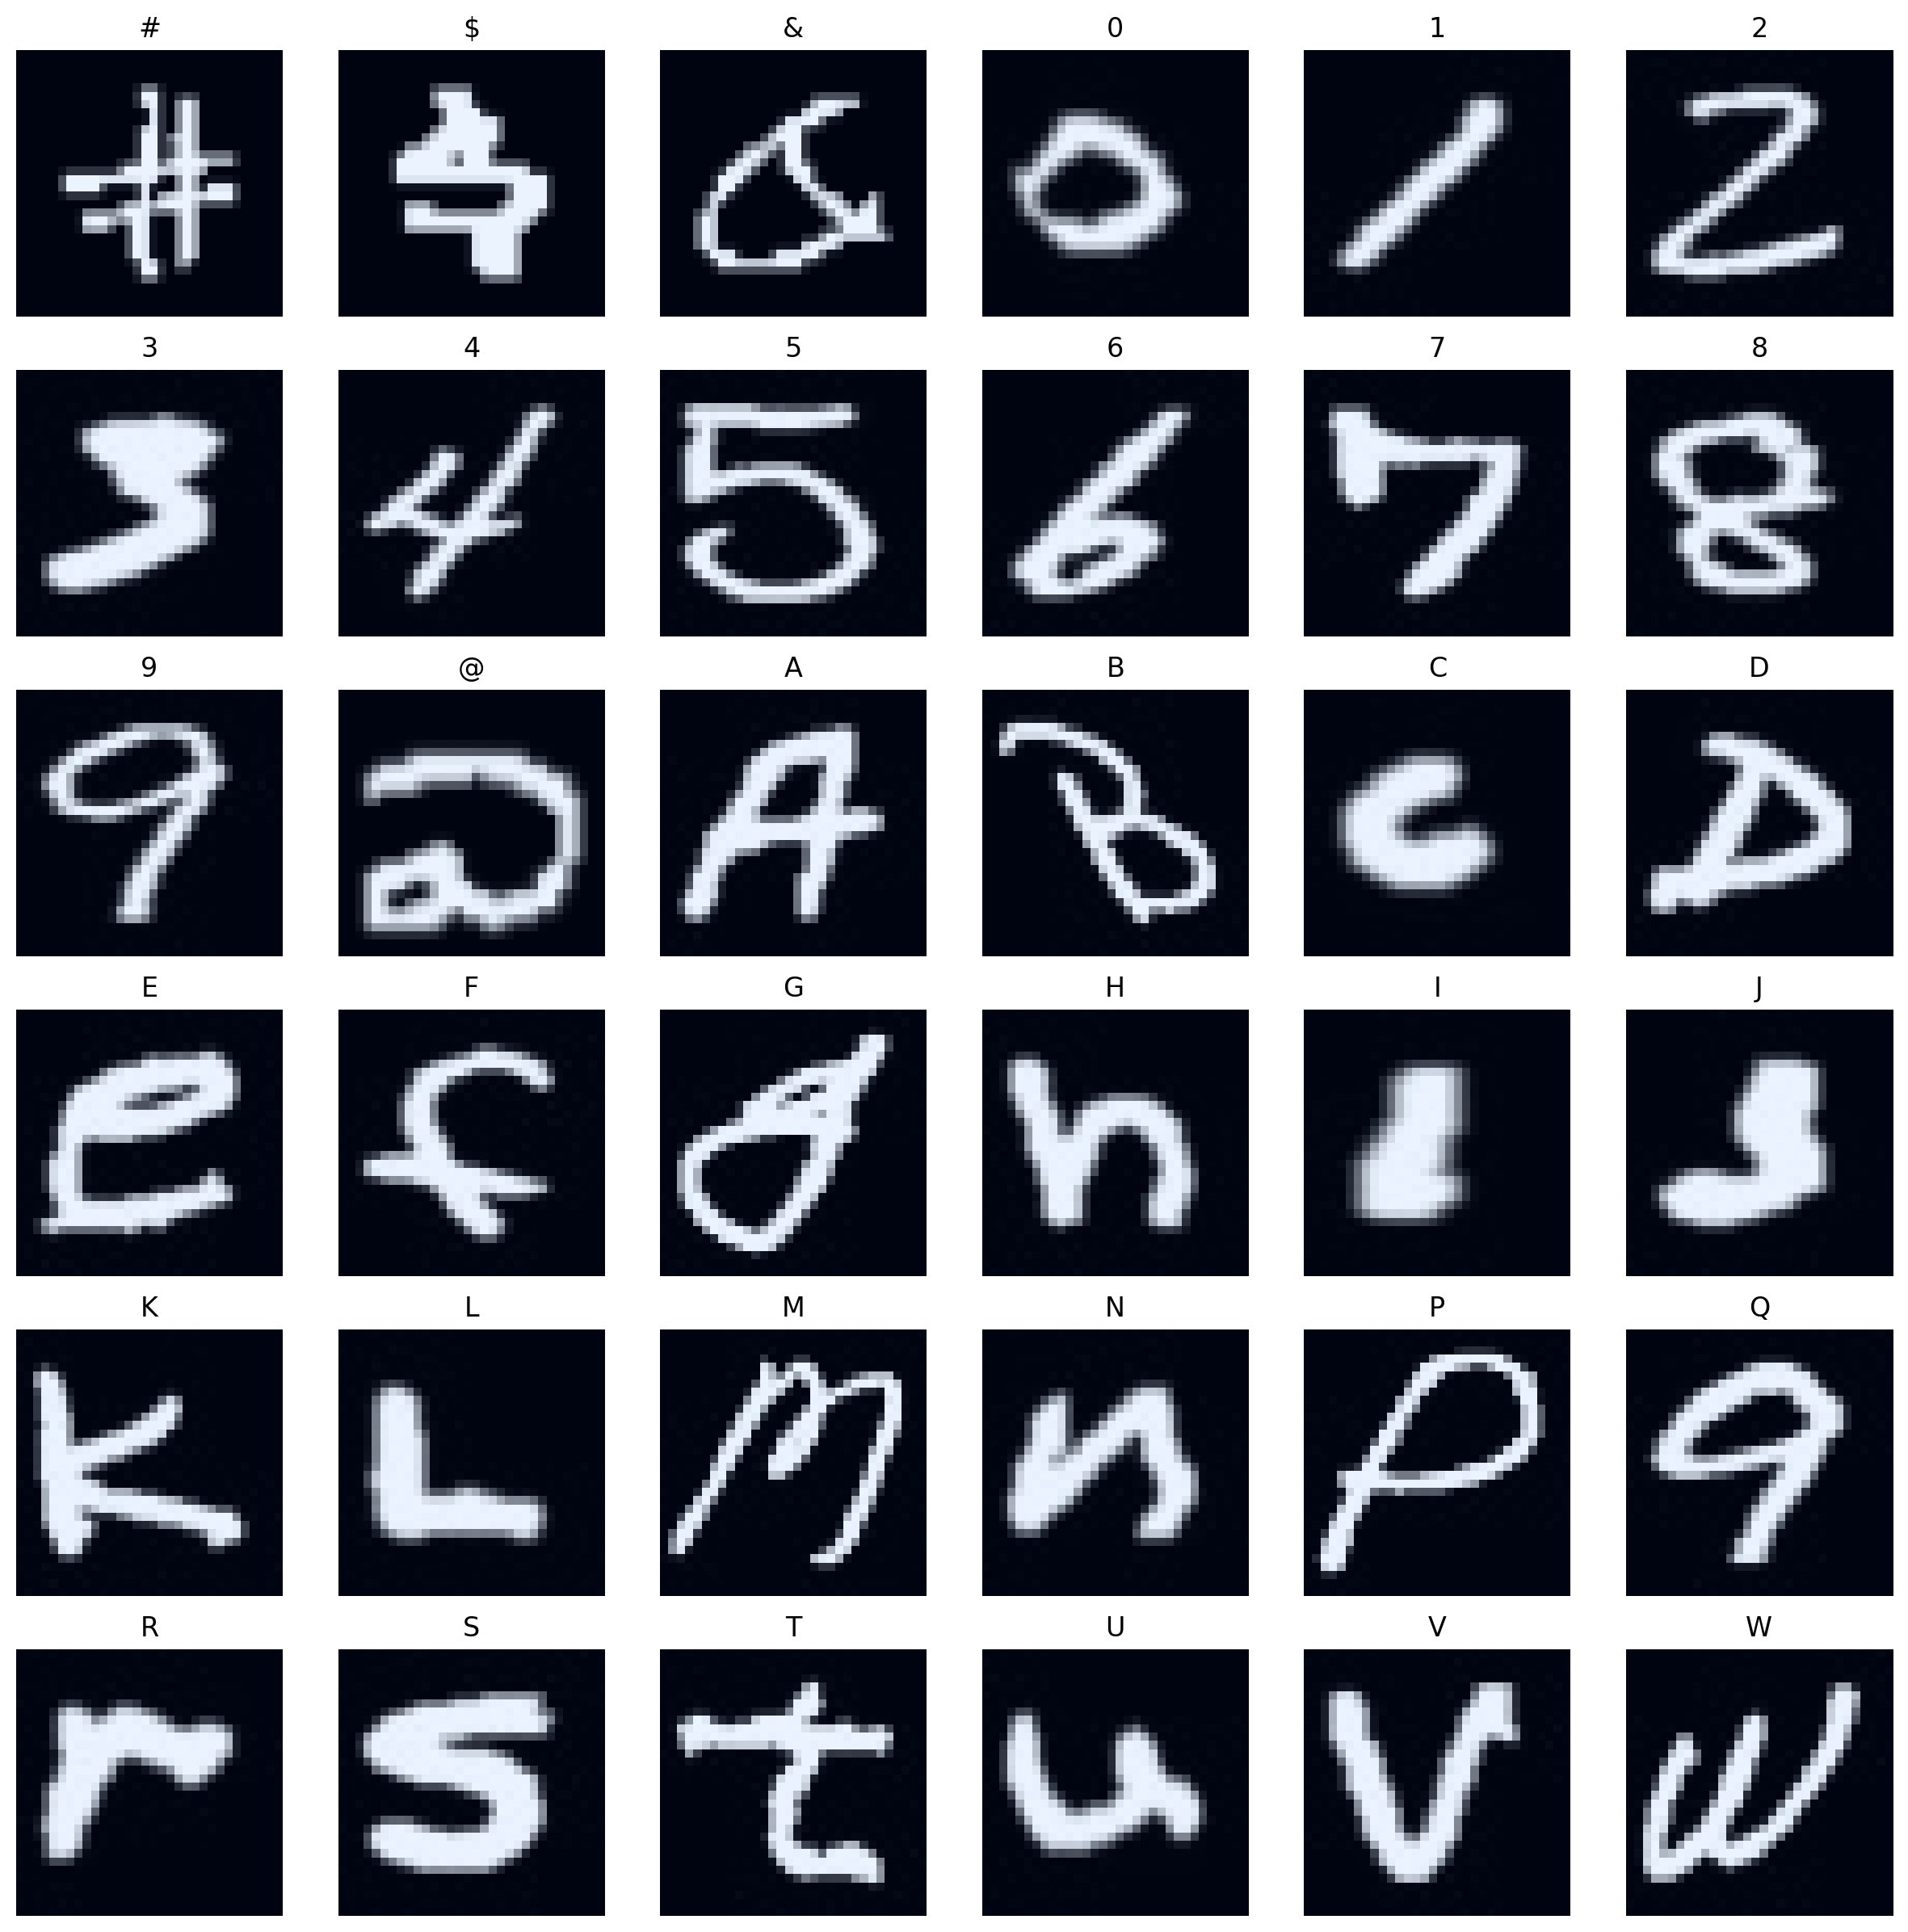

In [ ]:
plot_images(images, labels, classes)